# Imports

In [1]:
import os
import sys 
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics 
from sklearn.metrics import mean_squared_error

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Dropout

from scipy import stats
from datetime import datetime, date

from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

sns.set()
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('data/household_power_consumption.txt', sep=';', 
                   parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                   low_memory=False, na_values=['nan','?'], index_col='dt')

In [3]:
data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


# Exploratory data analysis

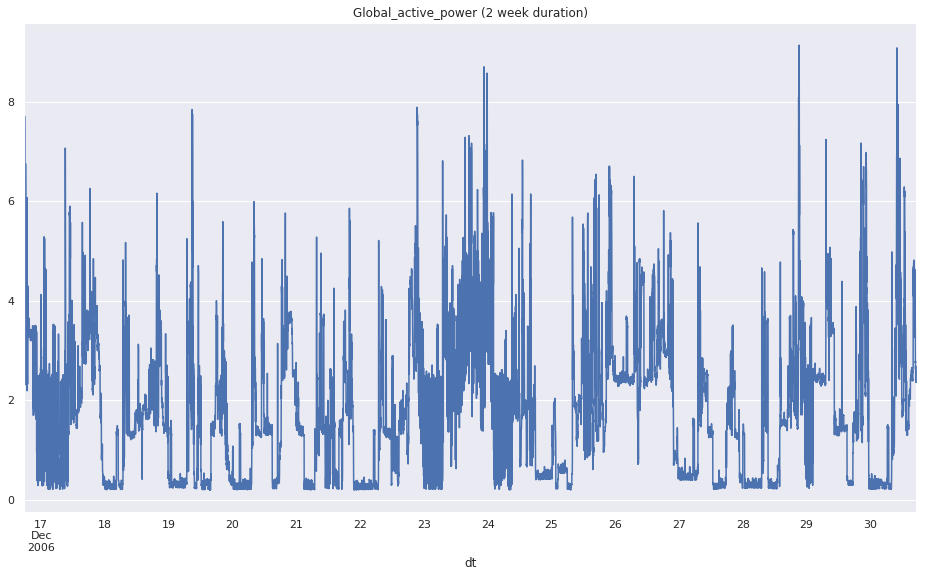

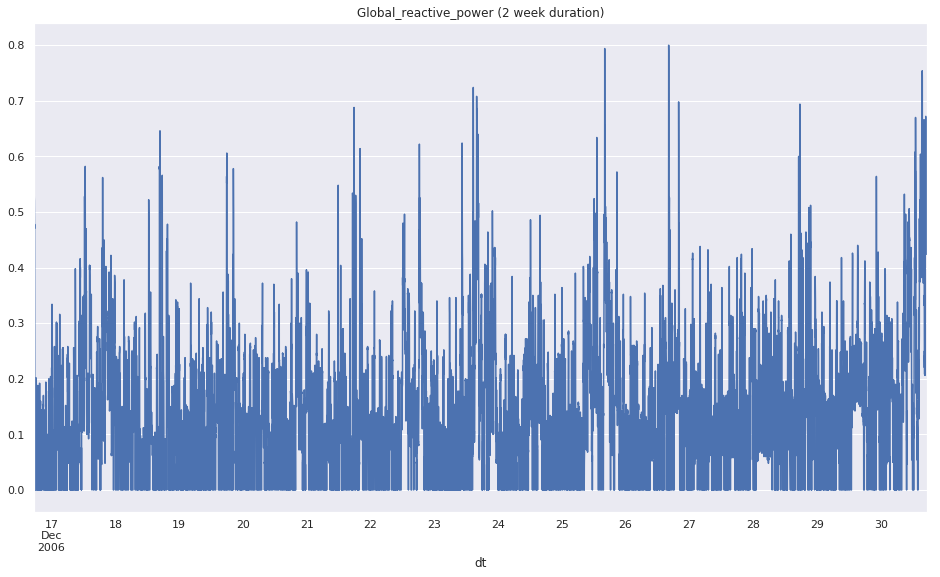

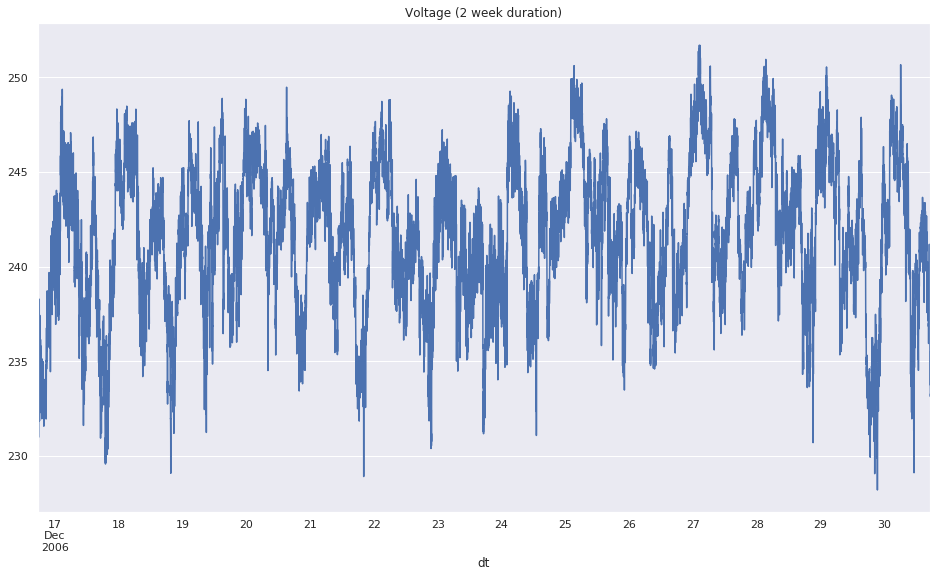

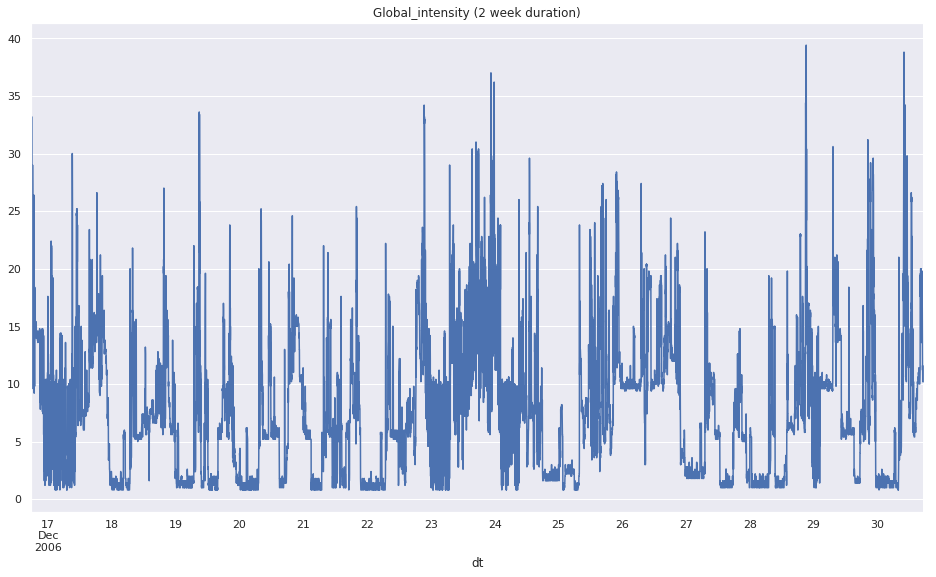

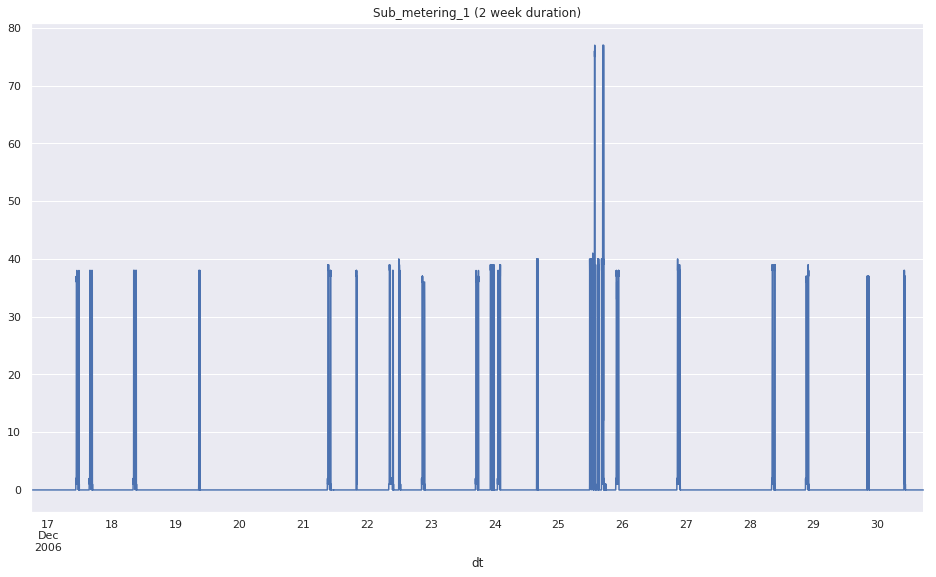

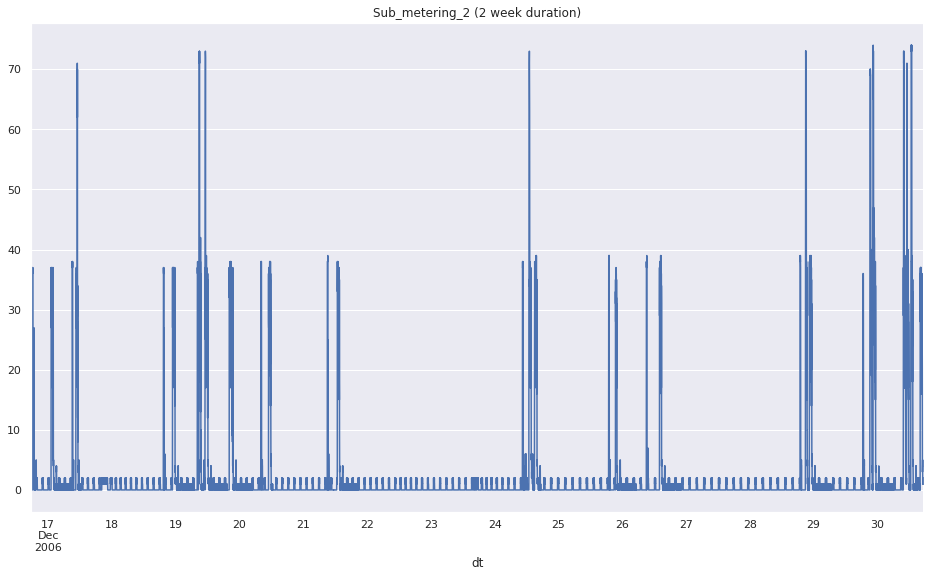

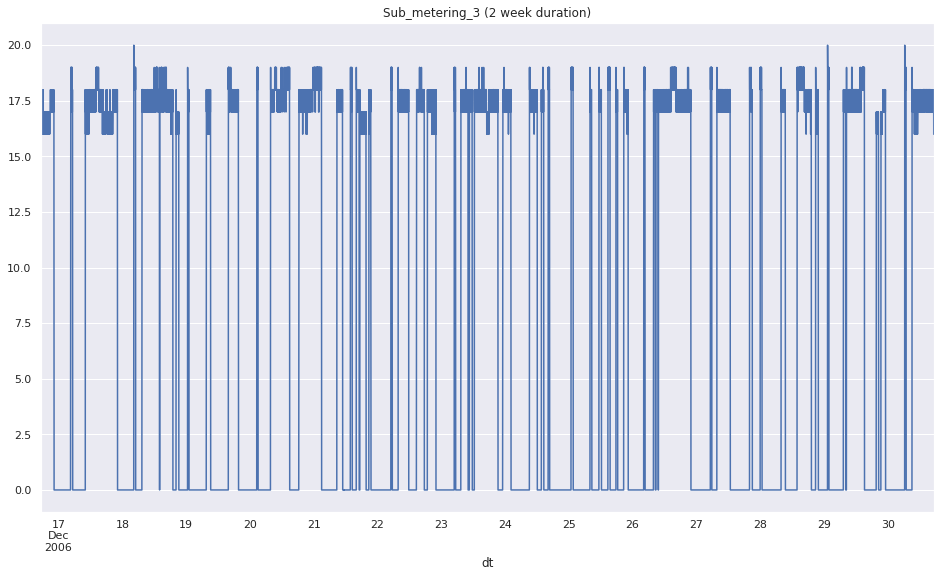

In [5]:
for column in data.columns:
    plt.figure(figsize=(16, 9))
    plt.title(f'{column} (2 week duration)')
    data[column][:60*24*14].plot()
    plt.show()

Для простоты будем работать с **дневным** потреблением электричества (*Global active power*), посмотрим внимательнее на данные.

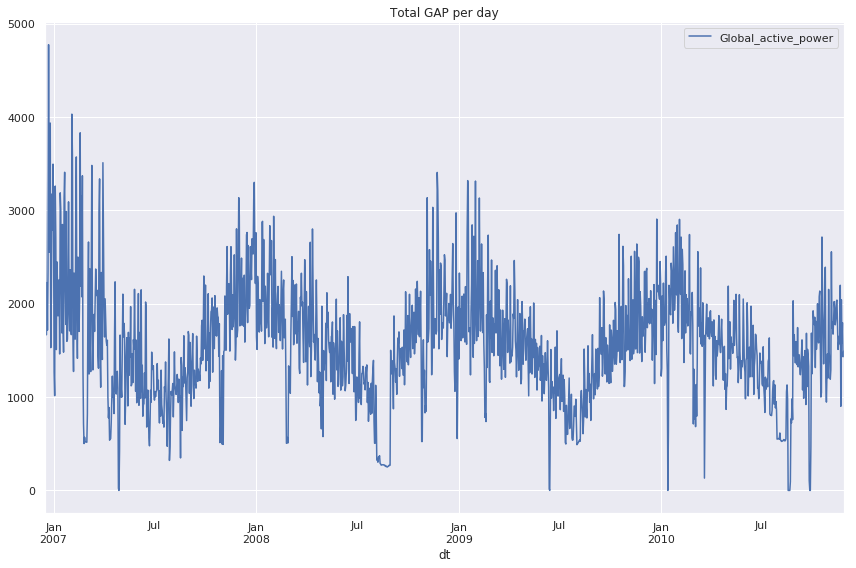

In [6]:
data[['Global_active_power']].resample('D').apply(sum).plot(title='Total GAP per day', figsize=(12, 8)) 
plt.tight_layout()
plt.show()

Видим несколько пиков в нуле. Достаточно странное поведение, учитывая что мы суммировали все возможные значения мощности за день. Посмотрим на изначальные данные.

In [7]:
data.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

В данных пропусков примерно на 18 дней, интерполируем пропущенные значения.

In [8]:
data.interpolate(method='time', inplace=True)
data.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [9]:
data['Global_active_power'].describe()

count    2.075259e+06
mean     1.090280e+00
std      1.052628e+00
min      7.600000e-02
25%      3.100000e-01
50%      6.140000e-01
75%      1.528000e+00
max      1.112200e+01
Name: Global_active_power, dtype: float64

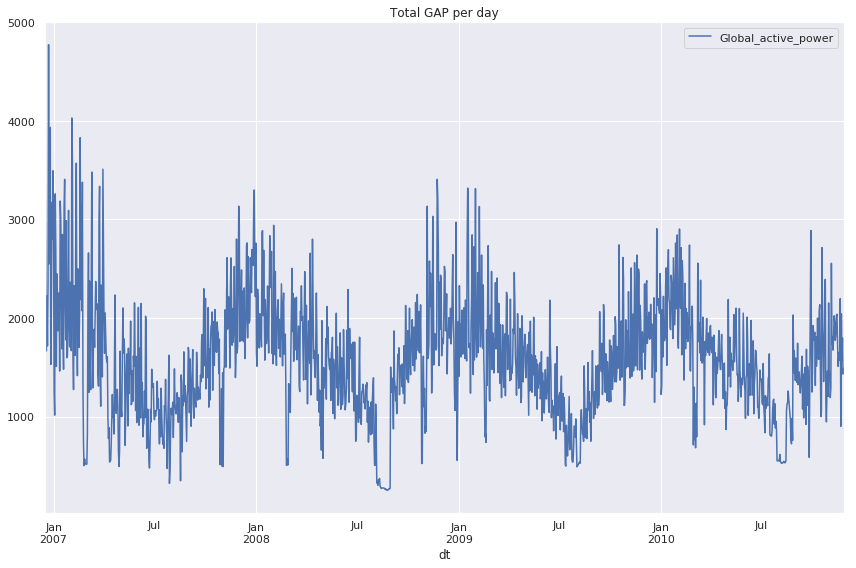

In [9]:
data[['Global_active_power']].resample('D').apply(sum).plot(title='Total GAP per day', figsize=(12, 8)) 
plt.tight_layout()
plt.show()

# Простые бейзлайн решения для прогнозирования рядов

## Предыдущий день

## Скользящее среднее

## Экспоненциальные сглаживания

# Fbprophet

Prophet был разработан для прогнозирования большого числа различных бизнес-показателей и строит достаточно хорошие default'ные прогнозы. Кроме того, он дает возможность, изменяя человеко-понятные параметры, улучшать прогноз и не требует от аналитиков глубоких знаний устройства предсказательных моделей.

Из минусов можно отметить достаточно небольшую точность предсказания "из коробки", для повышения качества придется повозиться с настройкой параметров. А так же странную работу (или отсутствие работы) с нестандартными периодами данных, например с часовыми тиками.

[Статья](https://research.fb.com/prophet-forecasting-at-scale/) от Facebook про Prophet.  
[Ссылка](https://facebook.github.io/prophet/docs/quick_start.html) на официальную документацию.

In [85]:
from fbprophet import Prophet

Библиотека **Prophet** имеет интерфейс похожий на *sklearn*, сначала мы создаем модель, затем вызываем у нее метод *fit* для тренировки и *predict* для предсказания. На вход методу *fit* библиотека принимает *dataframe* с двумя колонками:

**ds** — время, поле должно быть типа date или datetime,  
**y** — числовой показатель, который мы хотим предсказывать.

In [86]:
df = data[['Global_active_power']].copy()
df = df.resample('D').apply(sum)
df.reset_index(inplace=True)
df.columns = ['ds', 'y']

In [87]:
df.tail()

,ds,y
1437,2010-11-22,2041.536
1438,2010-11-23,1577.536
1439,2010-11-24,1796.248
1440,2010-11-25,1431.164
1441,2010-11-26,1488.104


In [88]:
# m = Prophet(changepoint_prior_scale=0.01).fit(df)
# future = m.make_future_dataframe(periods=300, freq='H')
# fcst = m.predict(future)
# fig = m.plot(fcst)

In [89]:
prediction_size = 31

df = data[['Global_active_power']].copy()
df = df.resample('D').apply(sum)
df.reset_index(inplace=True)
df.columns = ['ds', 'y']
df.tail()

,ds,y
1437,2010-11-22,2041.536
1438,2010-11-23,1577.536
1439,2010-11-24,1796.248
1440,2010-11-25,1431.164
1441,2010-11-26,1488.104


In [90]:
train_df = df[:-prediction_size]

In [91]:
model = Prophet(daily_seasonality=True)
model.fit(train_df)

/home/control/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning:

Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead



Для того что бы построить предсказания методу *predict* нужно передать *dataframe* с количеством записей, равным периоду, на который нужно предсказать.

In [92]:
future_dataframe = model.make_future_dataframe(periods=prediction_size, freq='D')
future_dataframe.tail()

,ds
1437,2010-11-22
1438,2010-11-23
1439,2010-11-24
1440,2010-11-25
1441,2010-11-26


In [93]:
forecast = model.predict(future_dataframe)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1437,2010-11-22,1256.592878,1509.264859,2514.244224,1256.500531,1256.687024,753.981302,753.981302,753.981302,347.387396,...,-130.351356,-130.351356,-130.351356,536.945263,536.945263,536.945263,0.0,0.0,0.0,2010.574180
1438,2010-11-23,1256.689284,1584.636928,2637.529121,1256.589571,1256.789432,870.111966,870.111966,870.111966,347.387396,...,-19.285752,-19.285752,-19.285752,542.010322,542.010322,542.010322,0.0,0.0,0.0,2126.801250
1439,2010-11-24,1256.785690,1601.709856,2685.025331,1256.677677,1256.892654,887.012466,887.012466,887.012466,347.387396,...,-3.948141,-3.948141,-3.948141,543.573212,543.573212,543.573212,0.0,0.0,0.0,2143.798156
1440,2010-11-25,1256.882096,1452.413443,2515.167870,1256.767649,1257.002434,728.828080,728.828080,728.828080,347.387396,...,-160.452695,-160.452695,-160.452695,541.893380,541.893380,541.893380,0.0,0.0,0.0,1985.710176
1441,2010-11-26,1256.978501,1512.218286,2635.866993,1256.855465,1257.110719,817.456432,817.456432,817.456432,347.387396,...,-67.231791,-67.231791,-67.231791,537.300828,537.300828,537.300828,0.0,0.0,0.0,2074.434933


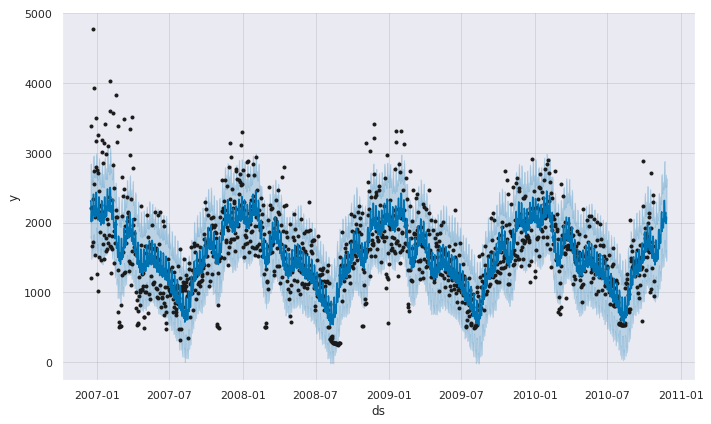

In [94]:
model.plot(forecast);

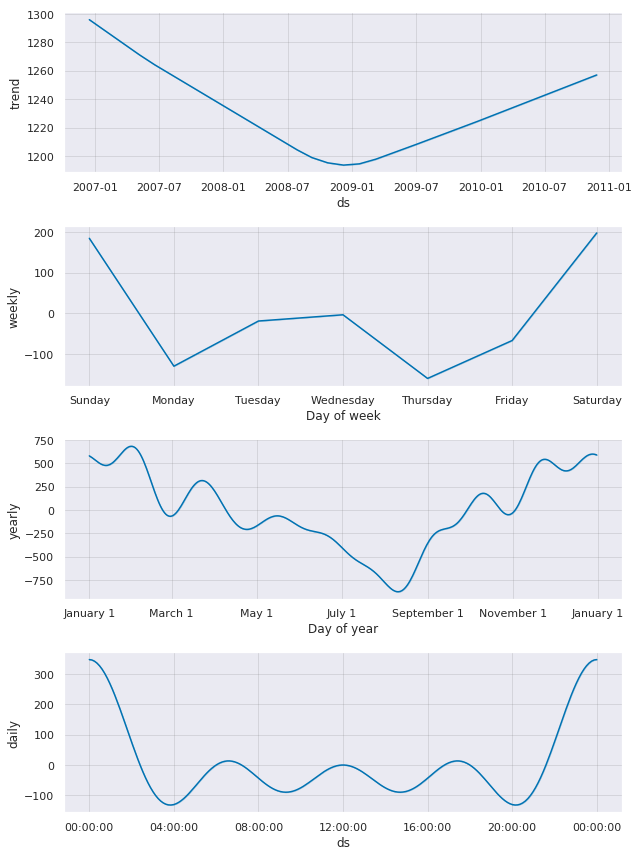

In [95]:
model.plot_components(forecast);

### Посчитаем ошибки прогноза:
MAPE (mean absolute percentage error) — это средняя абсолютная ошибка нашего прогноза. MAPE часто используется для оценки качества, поскольку эта величина относительная и по ней можно сравнивать качество даже на различных наборах данных.

$y_i$ - значение ряда в момент времени $i$.  
$\hat{y_i}$ - прогноз нашей модели в то же время.  

$e_i = y_i - \hat{y_i}$ - ошибка прогноза.  
$p_i = \frac{e_i}{y_i}$ - относительная ошибка прогноза.

$MAE = mean\space (\mid{e_i}\mid)$  
$MAPE = mean\space (\mid{p_i}\mid)$

In [96]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

In [97]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
       Return:
           tuple: (MAPE, MAE)
    """
    
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return error_mean('p'), error_mean('e')

In [98]:
cmp_df = make_comparison_dataframe(df, forecast)
mape, mae = calculate_forecast_errors(cmp_df, prediction_size)
print(f'MAPE = {mape},\nMAE = {mae}')

MAPE = 21.77352971197422,
MAE = 319.97705686656184


In [99]:
def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)

In [100]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="444"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=0),
                            marker=dict(color="444"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='y'), title=title, showlegend=True)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

In [101]:
show_forecast(cmp_df, prediction_size, 140, 'Prediction')

## Преобразование Бокса-Кокса

Это монотонное преобразование для данных, которое обычно используется для стабилизации дисперсии. Подробнее [здесь.](https://en.wikipedia.org/wiki/Power_transform) 

Для исходной последовательности $y = \{ y_1, \ldots, y_n \}, \quad y_i > 0, \quad i = 1,\ldots,n$ однопараметрическое преобразование Бокса-Кокса с параметром $\lambda$ определяется следующим образом:

$y_i^{\lambda} = \begin{cases}\frac{y_i^\lambda-1}{\lambda},&\text{if } \lambda \neq 0,\\ \log{(y_i)},& \text{if } \lambda = 0.\end{cases}$

Параметр $\lambda$ можно выбирать, максимизируя логарифм правдоподобия. Еще один способ поиска оптимального значения параметра основан на поиске максимальной величины коэффициента корреляции между квантилями функции нормального распределения и отсортированной преобразованной последовательностью.

In [102]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [103]:
df_with_boxcox = df.copy().set_index('ds')
df_with_boxcox['y'], lambda_ = stats.boxcox(df_with_boxcox['y'])
df_with_boxcox.reset_index(inplace=True)

In [104]:
lambda_

0.6665092992069518

In [105]:
pd.concat([df_with_boxcox, df.y], axis=1).head()

,ds,y,y
0,2006-12-16,168.598628,1209.176
1,2006-12-17,336.676585,3390.460
2,2006-12-18,252.276815,2203.826
3,2006-12-19,209.121696,1666.194
4,2006-12-20,253.956562,2225.748


In [106]:
train_df_wb = df_with_boxcox[:-prediction_size]

model_wb = Prophet(daily_seasonality=True)
model_wb.fit(train_df_wb)

In [107]:
future_df_wb = model_wb.make_future_dataframe(periods=prediction_size, freq='D')
future_df_wb.tail()

,ds
1437,2010-11-22
1438,2010-11-23
1439,2010-11-24
1440,2010-11-25
1441,2010-11-26


In [108]:
forecast_wb = model_wb.predict(future_df_wb)
forecast_wb.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1437,2010-11-22,174.650488,186.511999,284.055620,174.642575,174.655441,63.445583,63.445583,63.445583,27.024764,...,-10.676995,-10.676995,-10.676995,47.097814,47.097814,47.097814,0.0,0.0,0.0,238.096071
1438,2010-11-23,174.660136,201.282524,290.244330,174.651432,174.665878,73.338574,73.338574,73.338574,27.024764,...,-1.315032,-1.315032,-1.315032,47.628842,47.628842,47.628842,0.0,0.0,0.0,247.998710
1439,2010-11-24,174.669783,204.088089,295.095475,174.660073,174.676185,74.976195,74.976195,74.976195,27.024764,...,0.106383,0.106383,0.106383,47.845048,47.845048,47.845048,0.0,0.0,0.0,249.645979
1440,2010-11-25,174.679431,187.955299,281.484755,174.668699,174.686200,61.412692,61.412692,61.412692,27.024764,...,-13.378964,-13.378964,-13.378964,47.766892,47.766892,47.766892,0.0,0.0,0.0,236.092123
1441,2010-11-26,174.689079,199.586026,291.144383,174.677315,174.696660,69.475486,69.475486,69.475486,27.024764,...,-4.970501,-4.970501,-4.970501,47.421223,47.421223,47.421223,0.0,0.0,0.0,244.164565


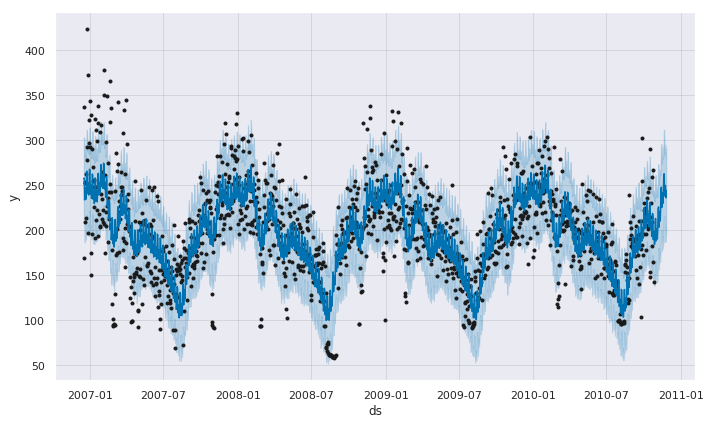

In [109]:
model_wb.plot(forecast_wb);

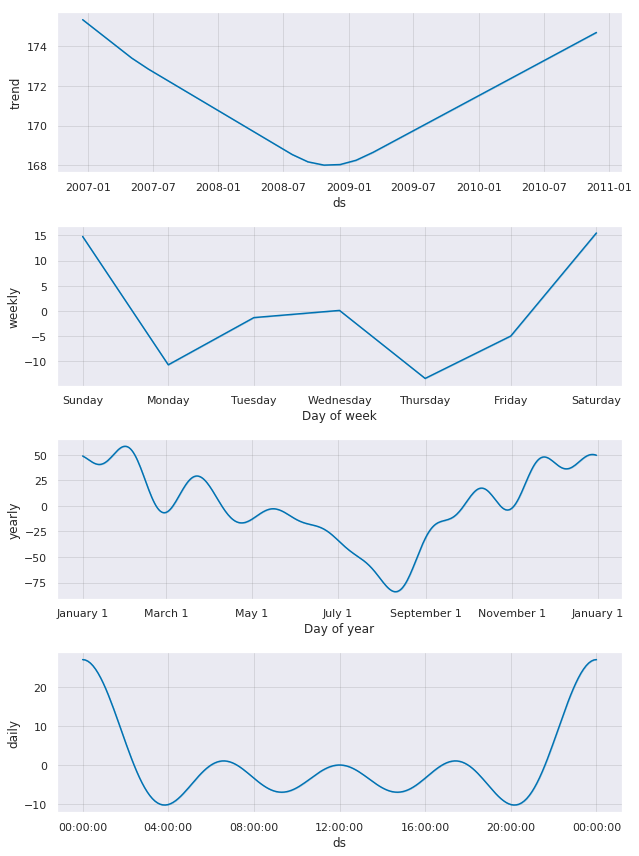

In [110]:
model_wb.plot_components(forecast_wb);

In [111]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_wb[column] = inverse_boxcox(forecast_wb[column], lambda_)

In [112]:
cmp_df_wb = make_comparison_dataframe(df, forecast_wb)
mape_wb, mae_wb = calculate_forecast_errors(cmp_df_wb, prediction_size)
print(f'MAPE = {mape:.2f}, MAPE with Box-Cox = {mape_wb:.2f}')
print(f'MAE = {mae:.2f}, MAE with Box-Cox = {mae_wb:.2f}')

MAPE = 21.77, MAPE with Box-Cox = 21.89
MAE = 319.98, MAE with Box-Cox = 322.91


In [113]:
show_forecast(cmp_df, prediction_size, 140, f'Prediction without transformation (MAPE = {mape:.2f})')
show_forecast(cmp_df_wb, prediction_size, 140, f'Prediction after Box-Cox (MAPE = {mape_wb:.2f})')

In [40]:
!mkdir ./models/fbprophet/
import pickle
with open('models/fbprophet/model_wb.pkl', 'wb') as f:
    pickle.dump(model_wb, f)

mkdir: cannot create directory ‘./models/fbprophet/’: File exists


# LightGBM

In [41]:
import lightgbm as lgb

**LightGBM** это одна из самых популярных библиотек для градиентного бустинга. Основные её преимущества в том, что она эффективна по памяти и действительно быстрая (бонусом идёт возможность работать с большими массивами данных и sparse матрицами).

[Ссылка](https://lightgbm.readthedocs.io/en/latest/) на официальную документацию.

In [42]:
def mean_encoding(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [43]:
def prepare_df(data, target_column, lag_start=1, lag_end=2, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for column in data.columns:
        for i in range(lag_start, lag_end):
            data[f"{column}_t-{i}"] = data[column].shift(i)
        if column != target_column:
            data.drop(column, axis=1, inplace=True)
        
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5, 6]) * 1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data[f'{target_column}_weekday_average'] = list(map(mean_encoding(data[:test_index], 'weekday',
                                                                      target_column).get, data.weekday))
    data[f"{target_column}_hour_average"] = list(map(mean_encoding(data[:test_index], 'hour',
                                                                   target_column).get, data.hour))

    # выкидываем закодированные средними признаки
    data.drop(["hour", "weekday"], axis=1, inplace=True)

    
    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([target_column], axis=1)
    y_train = data.loc[:test_index][target_column]
    X_test = data.loc[test_index:].drop([target_column], axis=1)
    y_test = data.loc[test_index:][target_column]
    
    return X_train, X_test, y_train, y_test

## Таск: придумать признаки для модели

In [44]:
X_train, X_test, y_train, y_test = prepare_df(data.resample('h').mean(),
                                              "Global_active_power",
                                              lag_end=7,
                                              test_size=0.15)

In [45]:
X_train.head()

,Global_active_power_t-1,Global_active_power_t-2,Global_active_power_t-3,Global_active_power_t-4,Global_active_power_t-5,Global_active_power_t-6,Global_reactive_power_t-1,Global_reactive_power_t-2,Global_reactive_power_t-3,Global_reactive_power_t-4,...,Sub_metering_2_t-6,Sub_metering_3_t-1,Sub_metering_3_t-2,Sub_metering_3_t-3,Sub_metering_3_t-4,Sub_metering_3_t-5,Sub_metering_3_t-6,is_weekend,Global_active_power_weekday_average,Global_active_power_hour_average
0,2.200133,3.056467,3.268567,3.400233,3.632200,4.222889,0.056167,0.076667,0.075100,0.085233,...,0.527778,4.433333,17.216667,16.783333,16.683333,16.866667,16.861111,1,1.270925,0.911849
1,2.061600,2.200133,3.056467,3.268567,3.400233,3.632200,0.071433,0.056167,0.076667,0.075100,...,6.716667,0.000000,4.433333,17.216667,16.783333,16.683333,16.866667,1,1.250129,0.662140
2,1.882467,2.061600,2.200133,3.056467,3.268567,3.400233,0.102433,0.071433,0.056167,0.076667,...,1.433333,0.000000,0.000000,4.433333,17.216667,16.783333,16.683333,1,1.250129,0.536781
3,3.349400,1.882467,2.061600,2.200133,3.056467,3.268567,0.136933,0.102433,0.071433,0.056167,...,0.000000,0.000000,0.000000,0.000000,4.433333,17.216667,16.783333,1,1.250129,0.476119
4,1.587267,3.349400,1.882467,2.061600,2.200133,3.056467,0.078233,0.136933,0.102433,0.071433,...,0.416667,0.000000,0.000000,0.000000,0.000000,4.433333,17.216667,1,1.250129,0.445037


In [46]:
# Логарифмируем таргет (частный случай преобразования Бокса-Кокса)
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [47]:
lgb_train = lgb.Dataset(X_train, y_train_log)
lgb_test = lgb.Dataset(X_test, y_test_log, reference=lgb_train)

In [48]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.005,
    'verbose': 0
}

gbm = lgb.train(params,
                lgb_train,
                verbose_eval=False,
                valid_sets=lgb_test,
                num_boost_round=10000,
                early_stopping_rounds=50)

## Таск: реализовать функции для подсчёта MAE, MAPE

In [49]:
def mean_abs_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

In [50]:
def mean_abs_percentage_error(y_true, y_pred):
     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
# Не забываем про обратное преобразование
y_pred = np.exp(gbm.predict(X_test))

# Сравним с наивным бейзлайном "завтра будет так же, как сегодня"
y_naive_pred = y_test.shift(1)

print(f'GBM MAE = {mean_abs_error(y_test, y_pred)}')
print(f'GBM MAPE = {mean_abs_percentage_error(y_test, y_pred)}\n')
print(f'Naïve MAE = {mean_abs_error(y_test, y_naive_pred)}')
print(f'Naïve MAPE = {mean_abs_percentage_error(y_test, y_naive_pred)}')

GBM MAE = 0.29329414120816744
GBM MAPE = 33.835129928517574

Naïve MAE = 0.37262652424883336
Naïve MAPE = 44.779014885699596


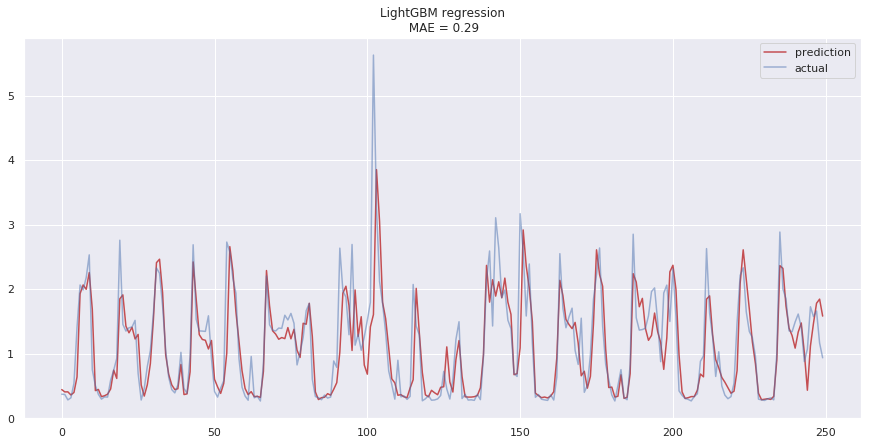

In [52]:
plt.figure(figsize=(15, 7))
plt.plot(y_pred[-250:], "r", label="prediction")
plt.plot(y_test.values[-250:], label="actual", alpha=0.5)
plt.legend(loc="best")
plt.title(f"LightGBM regression\n MAE = {mean_abs_error(y_test, y_pred):.2f}")
plt.grid(True);

In [53]:
!mkdir ./models/light_gmb/
gbm.save_model('models/light_gmb/weights.gbm')

mkdir: cannot create directory ‘./models/light_gmb/’: File exists


# ARIMA

## Краткая теория по временным рядам

В классических задачах анализа данных предполагается что все наблюдение независимы, однако при прогнозировании временных рядов, мы наоборот, надеемся, что значения ряда в прошлом содержат информацию о его поведении в будущем.

### Компоненты временных рядов:

**Тренд** — плавное долгосрочное изменение уровня ряда.  
**Сезонность** — циклические изменения уровня ряда с постоянным
периодом.  
**Цикл** — изменения уровня ряда с переменным периодом (экономические
циклы, периоды солнечной активности).  
**Ошибка** — непрогнозируемая случайная компонента ряда.


### Стационарность:

Под [**стационарностью**](https://ru.wikipedia.org/wiki/Стационарность) понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же [гомоскедастичность](https://ru.wikipedia.org/wiki/Гомоскедастичность)) и независимость ковариационной функции от времени (должна зависеть только от расстояния между наблюдениями).

Для нас это означает, что временные ряды с трендом и сезонностью - нестационарны. Цикличность, тем не менее, оставляет ряд стационарным, потому что нельзя заранее предсказать, где будут находиться минимумы или максимумы ряда.  

Почему стационарность так важна? По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

Бороться с нестационарностью можно множеством способов - дифференцированием, выделением тренда и сезонности, сглаживаниями и различными преобразованиями (логарифмирование, Бокс-Кокс).

Формально проверить гипотезу о стационарности ряда можно с помощью теста [Дики-Фуллера](https://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера). Однако всегда нужно смотреть на ряд глазами, потому что тесты в ряде случаях могут ошибаться. 

## Таск: Какие из представленных ниже временных рядов стационарны?

<img src="./images/download.png"/>

Знаменитая картинка из [лекции](https://www.youtube.com/watch?v=u433nrxdf5k) Евгения Рябенко о временных рядах. 

## Модель

Немного о модели: [ARIMA](https://ru.wikipedia.org/wiki/ARIMA) (autoregressive integrated moving average). Существует [теорема Вольда](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%92%D0%BE%D0%BB%D0%B4%D0%B0), которая говорит о том, что любой стационарный ряд может быть описан моделью ARIMA, а это значит, что наша задача в первую очередь привести ряд к стационарному виду, после чего производить моделирование.

In [117]:
df = data[['Global_active_power']].resample('D').apply(sum)
df.head()

,Global_active_power
dt,
2006-12-16,1209.176
2006-12-17,3390.460
2006-12-18,2203.826
2006-12-19,1666.194
2006-12-20,2225.748


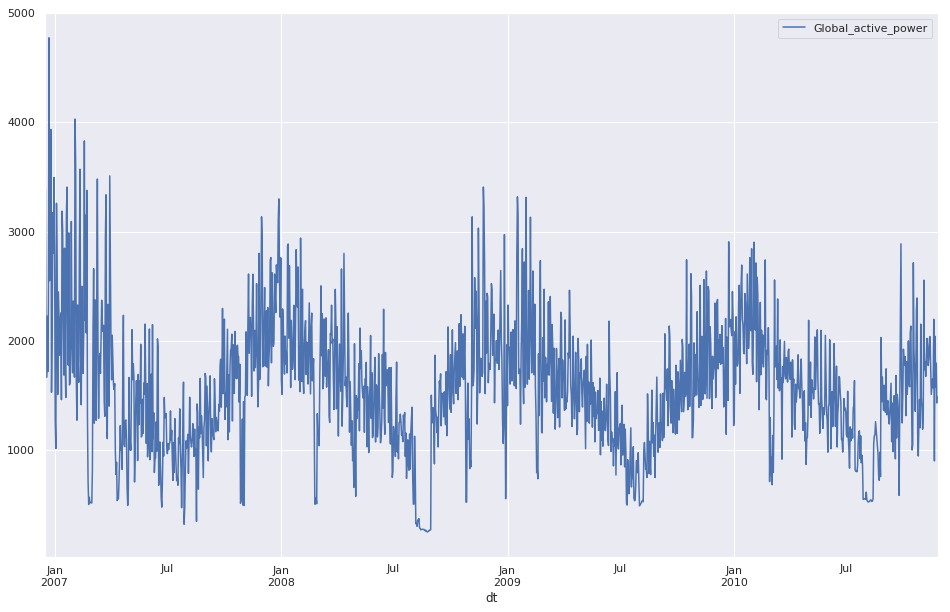

In [118]:
df.plot(figsize=(16, 10));

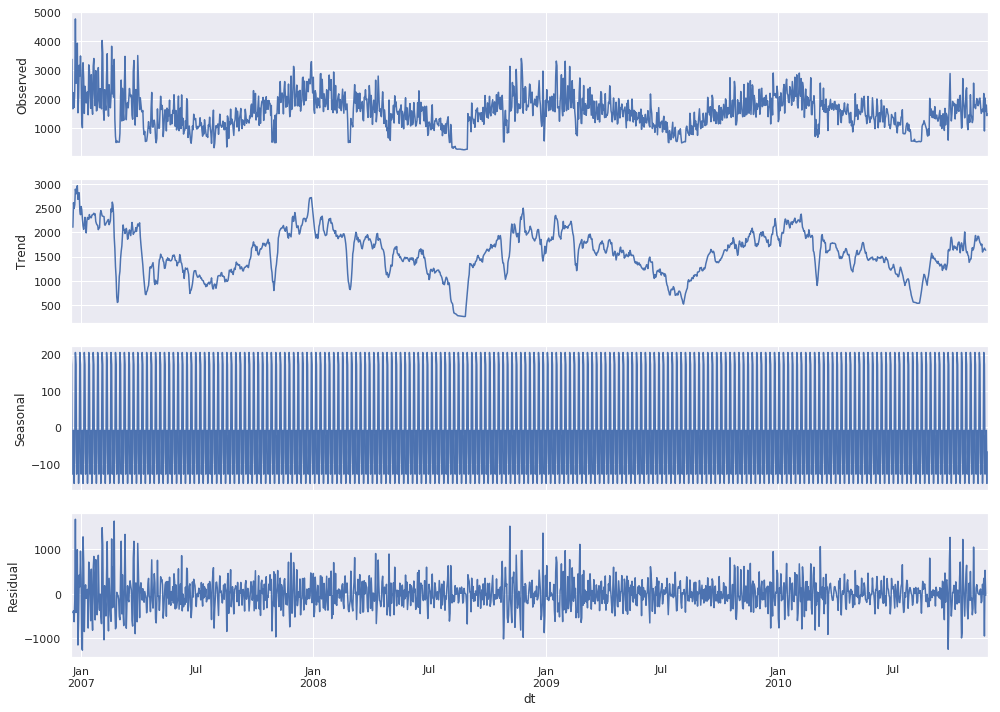

Критерий Дики-Фуллера: p=0.003972


In [119]:
from pylab import rcParams
rcParams['figure.figsize'] = (14, 10)

decomposition = sm.tsa.seasonal_decompose(df['Global_active_power'])
fig = decomposition.plot()
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power'])[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.666509
Критерий Дики-Фуллера: p=0.002410


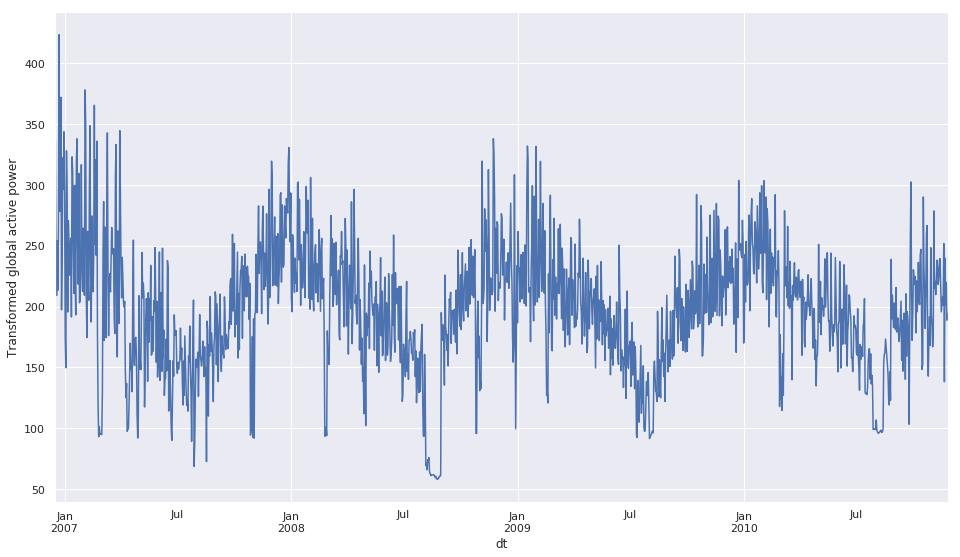

In [120]:
df['Global_active_power_box'], lambda_ = stats.boxcox(df['Global_active_power'])
df['Global_active_power_box'].plot(figsize=(16, 9));
plt.ylabel(u'Transformed global active power')

print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lambda_)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power_box'])[1])

Критерий Дики-Фуллера: p=0.000299


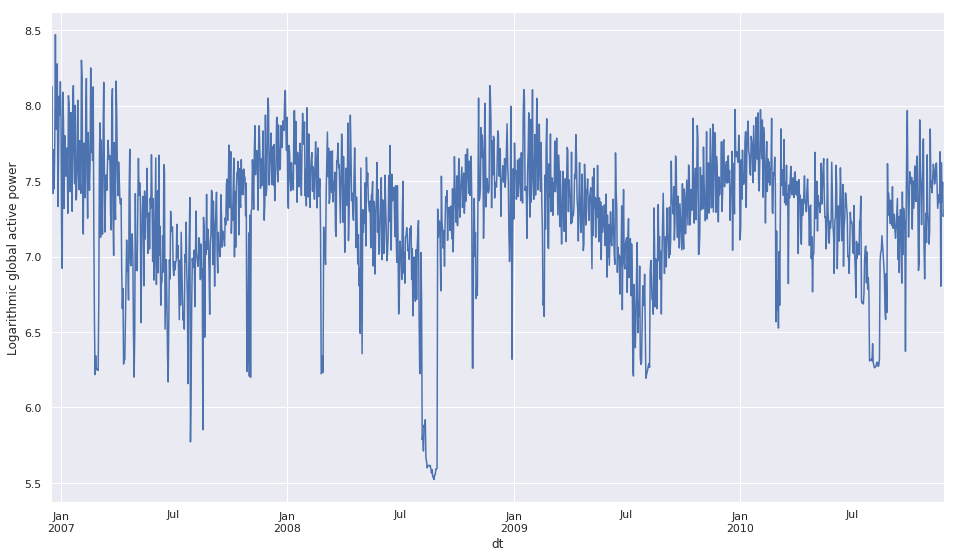

In [121]:
df['Global_active_power_log'] = np.log(df['Global_active_power'])
df['Global_active_power_log'].plot(figsize=(16, 9));
plt.ylabel(u'Logarithmic global active power')

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power_log'])[1])

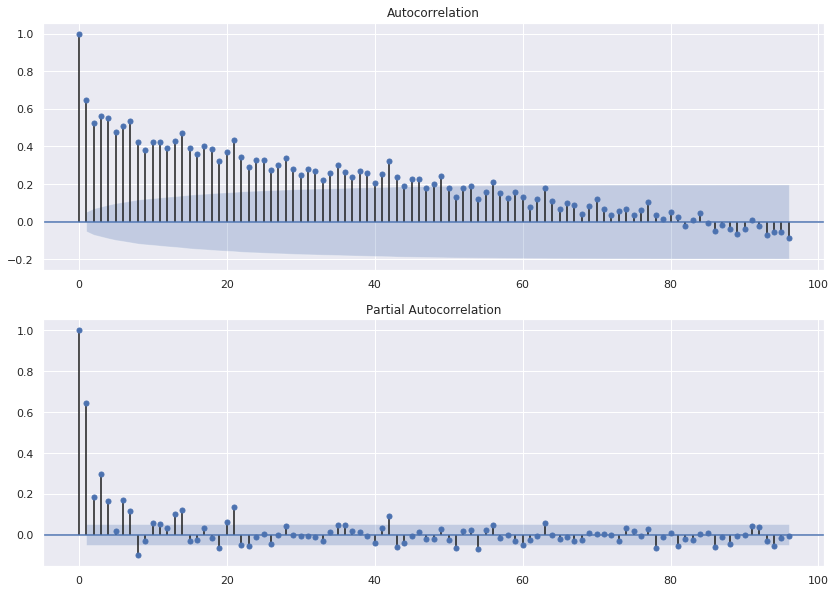

In [122]:
ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(df['Global_active_power_box'].dropna().values.squeeze(), lags=96, ax=ax)

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(df['Global_active_power_box'].dropna().values.squeeze(), lags=96, ax=ax)
plt.show()

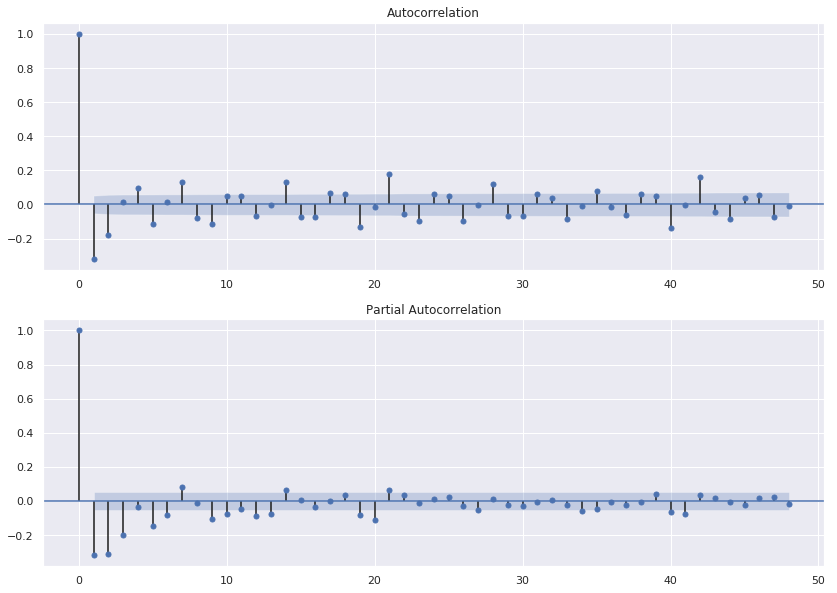

Критерий Дики-Фуллера: p=0.000000


In [123]:
df['Global_active_power_log_diff'] = df['Global_active_power_log'] - df['Global_active_power_log'].shift(1)

ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(df['Global_active_power_log_diff'].dropna().values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(df['Global_active_power_log_diff'].dropna().values.squeeze(), lags=48, ax=ax)
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power_log_diff'].dropna())[1])

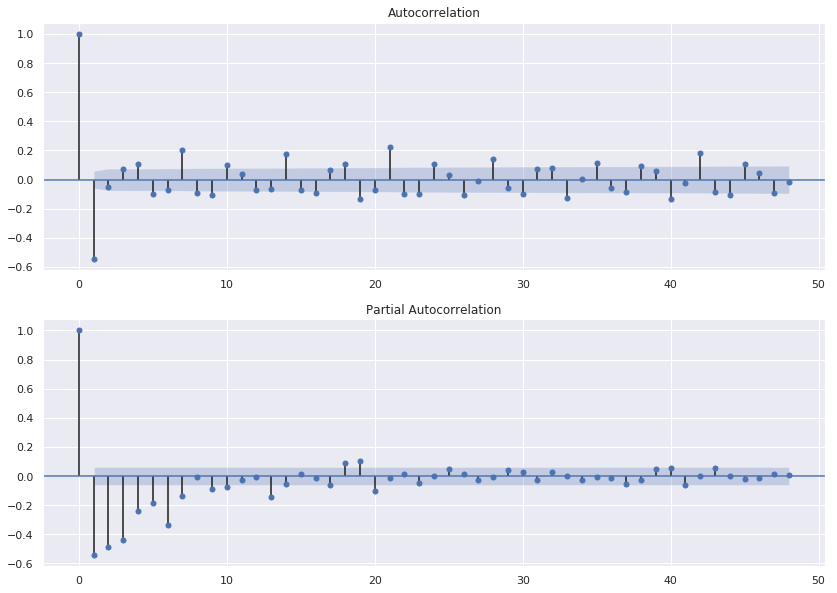

Критерий Дики-Фуллера: p=0.000000


In [124]:
df['Global_active_power_seasonal_log_diff'] = df['Global_active_power_log'] - df['Global_active_power_log'].shift(365)
df['Global_active_power_seasonal_d_log_diff'] = df['Global_active_power_seasonal_log_diff'] - df['Global_active_power_seasonal_log_diff'].shift(1)
df['Global_active_power_seasonal_d_log_diff2'] = df['Global_active_power_seasonal_d_log_diff'] - df['Global_active_power_seasonal_d_log_diff'].shift(1)

ax = plt.subplot(2, 1, 1)
sm.graphics.tsa.plot_acf(df['Global_active_power_seasonal_d_log_diff2'].dropna().values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_pacf(df['Global_active_power_seasonal_d_log_diff2'].dropna().values.squeeze(), lags=48, ax=ax)
plt.show()

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df['Global_active_power_seasonal_d_log_diff2'].dropna())[1])

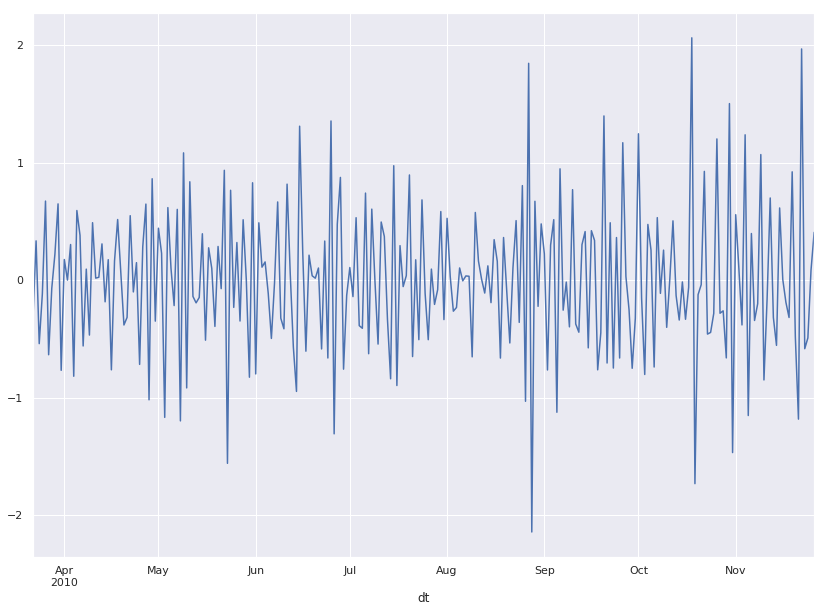

In [125]:
df[-250:]['Global_active_power_seasonal_d_log_diff2'].plot()

In [28]:
ps, Ps = range(0, 4), range(0, 3)
qs, Qs = range(0, 4), range(0, 3)
d, D = 1, 1

In [62]:
# import itertools
# import warnings

# parameters = itertools.product(ps, qs, Ps, Qs)
# results = []
# best_aic = float("inf")
# warnings.filterwarnings('ignore')

# for parameter in list(parameters):
#     # Модель обучается не на всех наборах параметров
#     try:
#         model=sm.tsa.statespace.SARIMAX(df['Global_active_power_log'], order=(parameter[0], d, parameter[1]), 
#                                         seasonal_order=(parameter[2], D, parameter[3], 12)).fit(disp=-1)
#     # Выводим параметры, на которых модель не обучается и переходим к следующему набору
#     except ValueError:
#         print('wrong parameters:', parameter)
#         continue
#     aic = model.aic
#     # Сохраняем лучшую модель, aic, параметры
#     if aic < best_aic:
#         best_model = model
#         best_aic = aic
#         best_parameter = parameter
#     results.append([parameter, model.aic])
    
# warnings.filterwarnings('default')

In [63]:
# result_table = pd.DataFrame(results)
# result_table.columns = ['parameters', 'aic']
# result_table.sort_values(by='aic', ascending=True).head()

### EXPERIMENT

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm

In [60]:
day_ns = df['Global_active_power_log'].index.dayofyear
day_ns

Int64Index([350, 351, 352, 353, 354, 355, 356, 357, 358, 359,
            ...
            321, 322, 323, 324, 325, 326, 327, 328, 329, 330],
           dtype='int64', name='dt', length=1442)

In [43]:
exog_season = patsy.dmatrix('bs(day_ns, df=4)')
print(exog_season.shape)
print(exog_season[:5])

(1442, 5)
[[1.00000000e+00 1.66189083e-04 1.07133006e-02 2.26787144e-01
  7.62333366e-01]
 [1.00000000e+00 1.36935584e-04 9.45225629e-03 2.14464665e-01
  7.75946143e-01]
 [1.00000000e+00 1.11333702e-04 8.26556018e-03 2.01903090e-01
  7.89720017e-01]
 [1.00000000e+00 8.91399938e-05 7.15417946e-03 1.89100747e-01
  8.03655934e-01]
 [1.00000000e+00 7.01110193e-05 6.11908132e-03 1.76055966e-01
  8.17754842e-01]]


In [45]:
res_ols = sm.OLS(df['Global_active_power_log'].values, exog_season).fit()

In [46]:
horizon = 70
n_disp = 6 * 20
predicted_ols = np.concatenate((res_ols.fittedvalues[-n_disp:], 
                                res_ols.predict(exog_season[:horizon])))

In [49]:
exog_season2 = exog_season[:, 1:]  # bug/requirement: no constant in exog

res_arma = sm.tsa.SARIMAX(df['Global_active_power_log'].values, order=(3, d, 1), 
                          seasonal_order=(2, D, 2, 12), exog=exog_season2).fit(iprint=0)

/home/control/.local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [56]:
day_ns.shape

(1442,)

In [54]:
exog_season2.shape

(1442, 4)

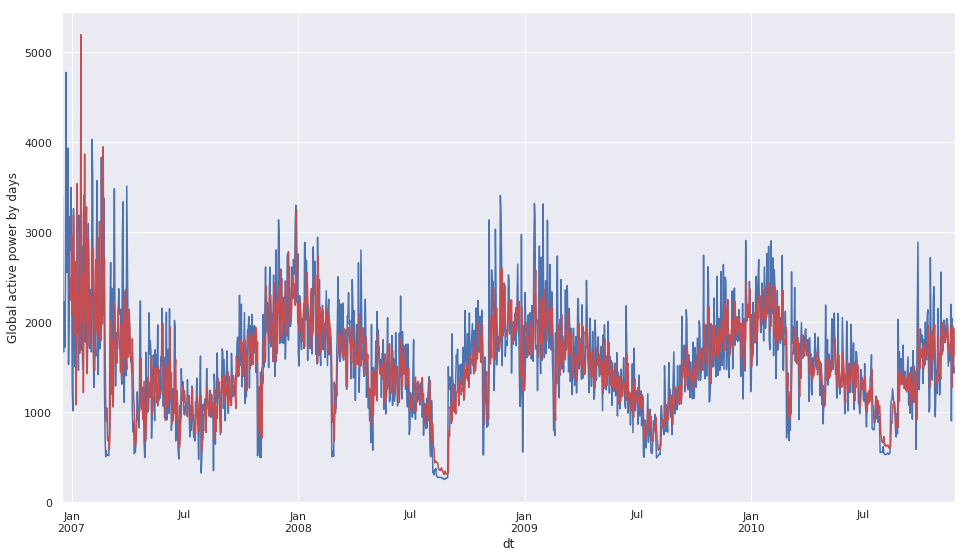

In [50]:
df['model'] = np.exp(res_arma.fittedvalues)
plt.figure(figsize=(16, 9))
df['Global_active_power'].plot()
df['model'].dropna()[14:].plot(color='r')
plt.ylabel('Global active power by days')
plt.show()

In [75]:
pd.date_range(df['Global_active_power'].index[-1], periods=32, freq='D').dayofyear[1:].shape

(31,)

In [66]:
day_ns[16+330:]

Int64Index([331, 332, 333, 334, 335, 336, 337, 338, 339, 340,
            ...
            321, 322, 323, 324, 325, 326, 327, 328, 329, 330],
           dtype='int64', name='dt', length=1096)

In [129]:
pred_values = np.exp(res_arma.forecast(365, exog=exog_season2[16+330:16+330+365, :]))

In [115]:
pred_values.shape

(75,)

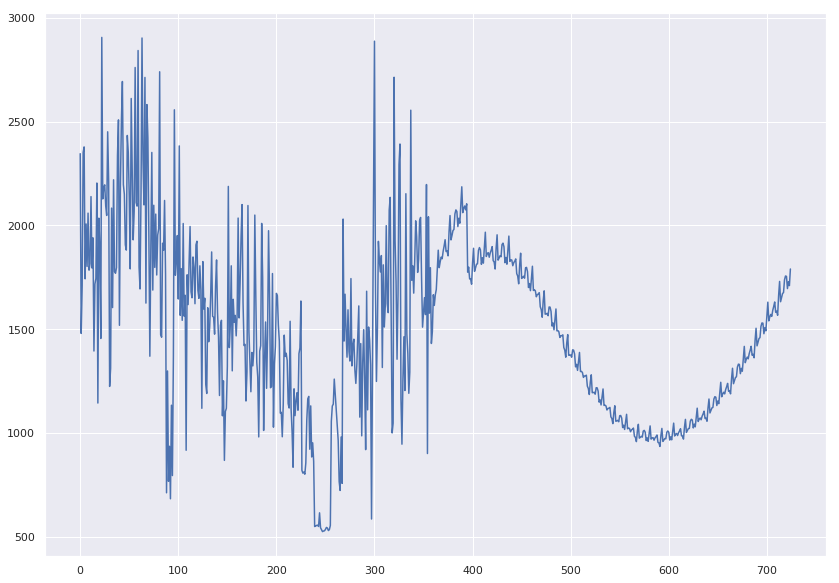

In [130]:
plt.plot(np.concatenate([df['Global_active_power'].values[-360:], pred_values]))

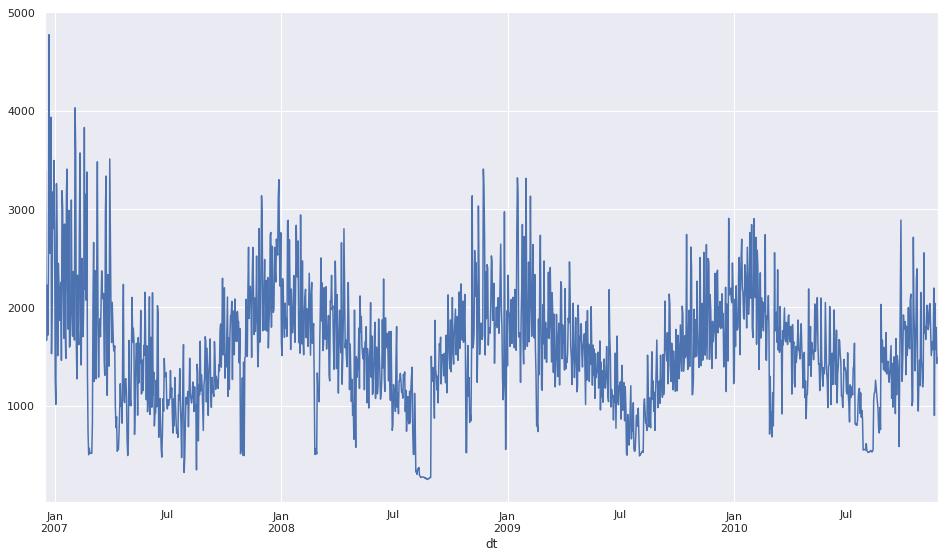

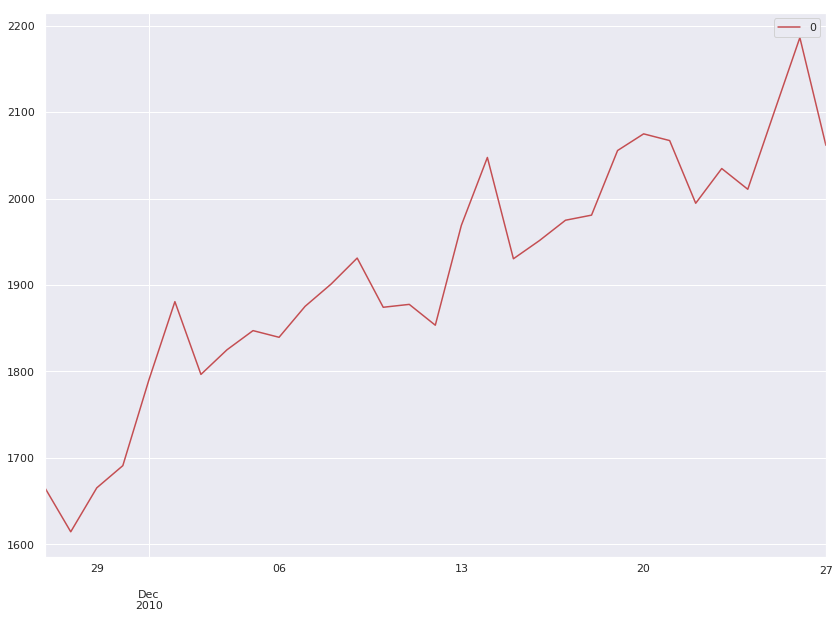

In [80]:
df['Global_active_power'].plot(figsize=(16, 9))
pd.DataFrame(np.exp(res_arma.forecast(31, exog=exog_season2[16+330:16+330+31, :])), index=pd.date_range(df['Global_active_power'].index[-1], periods=32, freq='D')[1:]).plot(color='r')

### Best model

In [30]:
params = (3, 1, 2, 2)
best_model=sm.tsa.statespace.SARIMAX(df['Global_active_power_log'], order=(params[0], d, params[1]), 
                                seasonal_order=(params[2], D, params[3], 12)).fit(disp=-1)

KeyboardInterrupt: 

Критерий Стьюдента: p=0.677985
Критерий Дики-Фуллера: p=0.000000


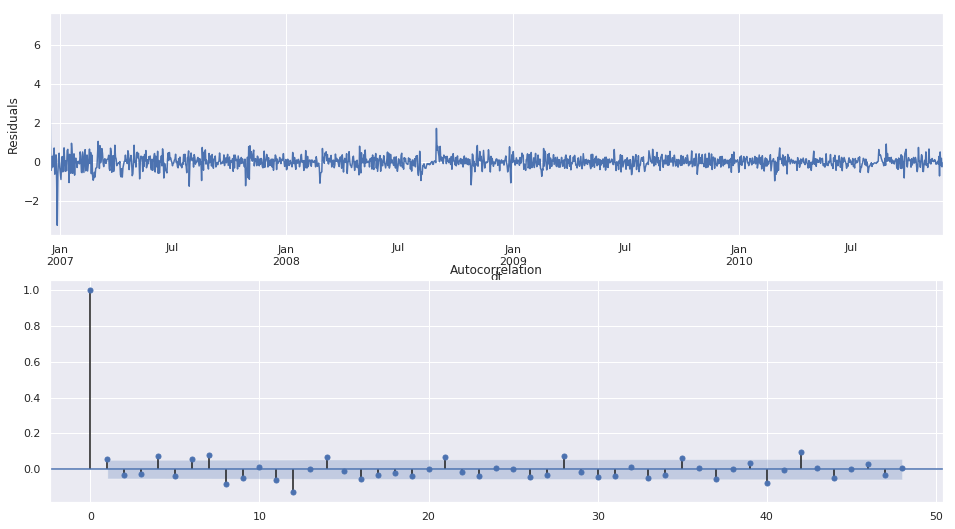

In [65]:
plt.figure(figsize=(16, 9))
plt.subplot(2, 1, 1)
best_model.resid.dropna().plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(best_model.resid.dropna().values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid.dropna(), 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid.dropna())[1])

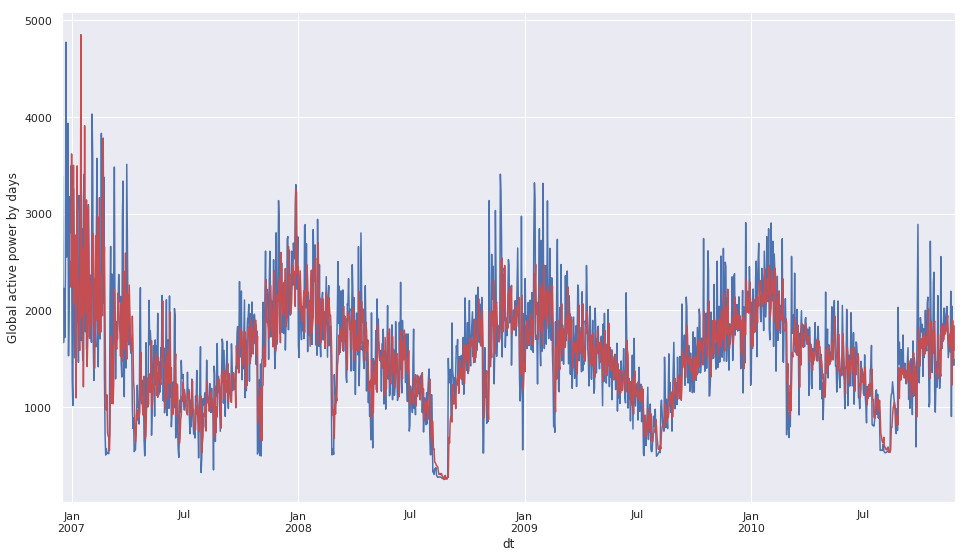

In [66]:
df['model'] = np.exp(best_model.fittedvalues)
plt.figure(figsize=(16, 9))
df['Global_active_power'].plot()
df['model'].dropna()[14:].plot(color='r')
plt.ylabel('Global active power by days')
plt.show()

/home/control/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



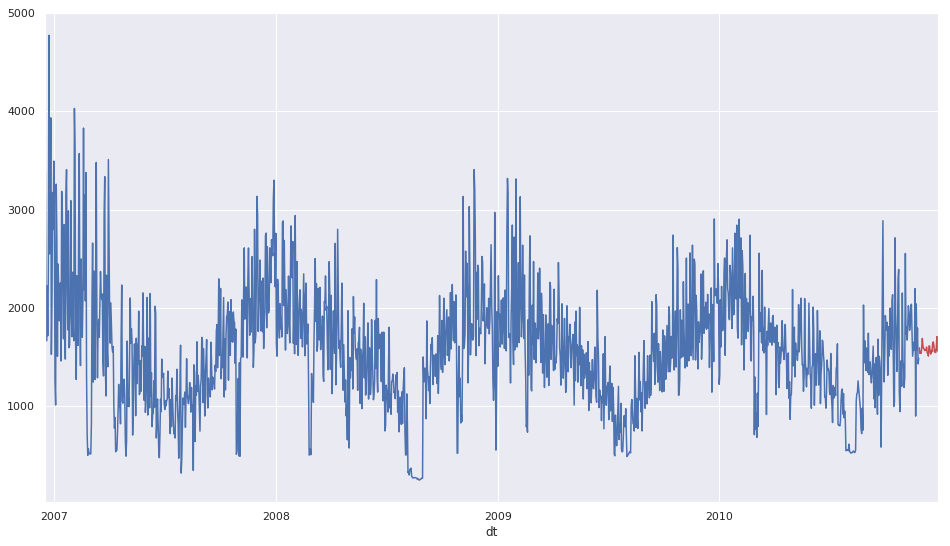

In [67]:
df['Global_active_power'].plot(figsize=(16, 9))
np.exp(best_model.forecast(31)).plot(color='r');

In [70]:
sarima_folder = os.path.join('models', 'sarima')
!mkdir -p {sarima_folder}

In [71]:
best_model.save(os.path.join(sarima_folder, 'model.sa'))

# LSTM

In [69]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [70]:
df_resample = data.resample('h').mean() 
df_resample.shape

(34589, 7)

In [71]:
values = df_resample.values 

In [72]:
# aaa

In [73]:
values = data.resample('h').mean().values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
lstm_data = pd.DataFrame(scaled, columns=data.columns, index=data.resample('h').mean().index)

In [74]:
train_X, test_X, train_y, test_y = prepare_df(lstm_data,
                                              "Global_active_power",
                                              lag_end=7,
                                              test_size=0.15)

In [75]:
train_y.head()

0    0.301032
1    0.273201
2    0.501108
3    0.227338
4    0.238980
Name: Global_active_power, dtype: float64

In [76]:
train_y = train_y.values
test_y = test_y.values
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(29401, 1, 45) (29401,) (5183, 1, 45) (5183,)


In [77]:
# aaa

In [78]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [83]:
reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[8:], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.687521  0.545045  
2   0.687748  0.509006  
3   0.680272  0.488550  
4   0.684350  0.455597  
5   0.702019  0.322555  


In [84]:
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


In [85]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(70))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 8760 samples, validate on 25828 samples
Epoch 1/20
 - 3s - loss: 0.0214 - val_loss: 0.0110
Epoch 2/20
 - 1s - loss: 0.0123 - val_loss: 0.0099
Epoch 3/20
 - 1s - loss: 0.0114 - val_loss: 0.0098
Epoch 4/20
 - 1s - loss: 0.0111 - val_loss: 0.0094
Epoch 5/20
 - 1s - loss: 0.0109 - val_loss: 0.0096
Epoch 6/20
 - 1s - loss: 0.0108 - val_loss: 0.0098
Epoch 7/20
 - 1s - loss: 0.0108 - val_loss: 0.0095
Epoch 8/20
 - 1s - loss: 0.0107 - val_loss: 0.0094
Epoch 9/20
 - 1s - loss: 0.0106 - val_loss: 0.0095
Epoch 10/20
 - 1s - loss: 0.0107 - val_loss: 0.0093
Epoch 11/20
 - 1s - loss: 0.0106 - val_loss: 0.0094
Epoch 12/20
 - 1s - loss: 0.0106 - val_loss: 0.0094
Epoch 13/20
 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 14/20
 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 15/20
 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 16/20
 - 1s - loss: 0.0106 - val_loss: 0.0093
Epoch 17/20
 - 1s - loss: 0.0105 - val_loss: 0.0092
Epoch 18/20
 - 1s - loss: 0.0105 - val_loss: 0.0092
Epoch 19/20
 - 1s - loss

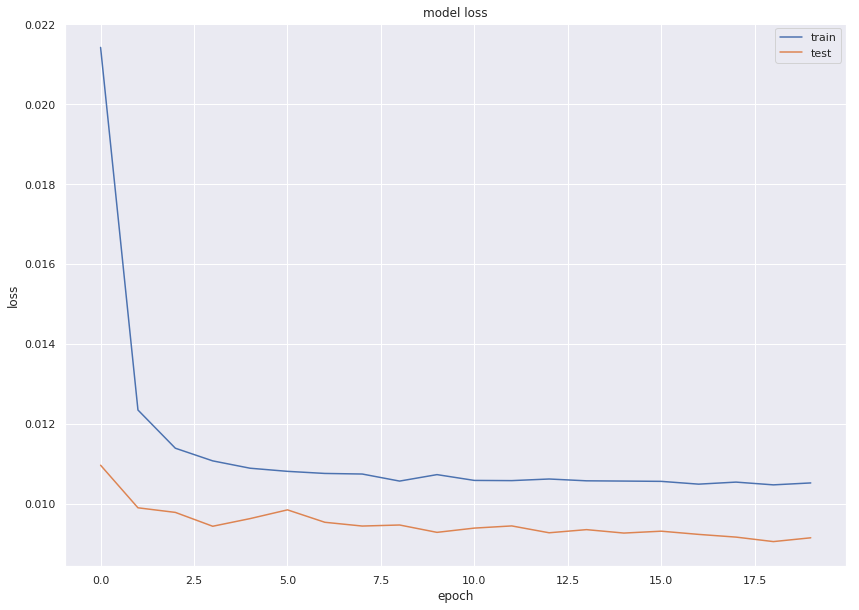

In [86]:
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [87]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[-1]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.615


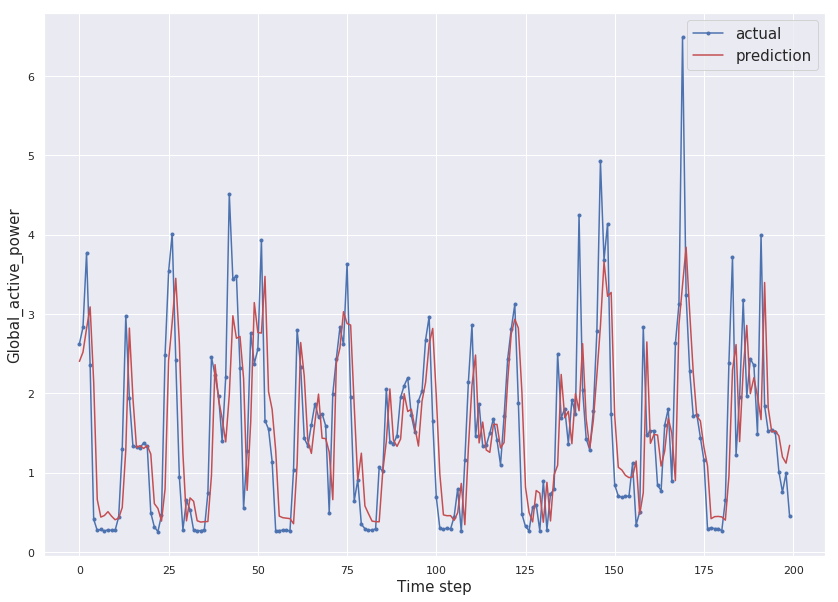

In [88]:
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

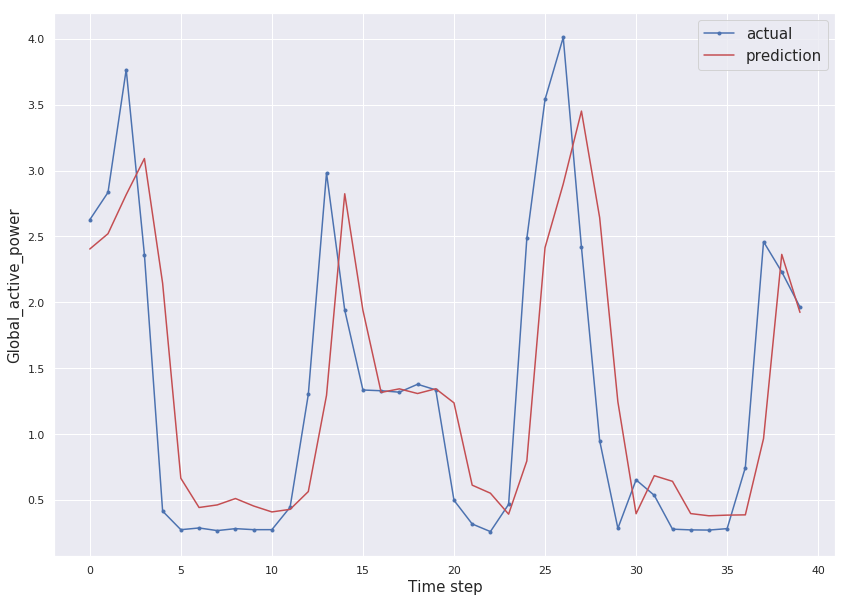

In [98]:
aa=[x for x in range(40)]
plt.plot(aa, inv_y[:40], marker='.', label="actual")
plt.plot(aa, inv_yhat[:40], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [89]:
print(f'GBM MAE = {mean_abs_error(inv_y, inv_yhat)}')
print(f'GBM MAPE = {mean_abs_percentage_error(inv_y, inv_yhat)}\n')

GBM MAE = 0.4683085199985024
GBM MAPE = 72.50232812085909



In [90]:
model_folder = os.path.join('models', 'lstm_keras')
model_json_path = os.path.join(model_folder, 'model.json')
weights_path = os.path.join(model_folder, 'weights.hd5')
scaler_path = os.path.join(model_folder, 'scaler.pkl')

In [91]:
np.expand_dims(test_X[0:1], 0).shape

(1, 1, 7)

In [92]:
test_y[0]

array([0.38881696])

In [93]:
model.predict(np.expand_dims(test_X[0:1], 0))

array([[0.35431698]], dtype=float32)

In [99]:
!mkdir -p {model_folder}

In [95]:
with open(model_json_path, 'w') as f:
    json.dump(model.to_json(), f)
model.save_weights(weights_path)

In [96]:
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)